# Generating Super-Resolution Images

This notebook provides you with a complete code example to increase the resolution of microscopy images using a diffusion model.

## Downloading the BioSR Dataset

In [18]:
import os

if not os.path.exists("biosr_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/biosr_dataset")

## Managing the Dataset

In [19]:
import torch
from tifffile import tifffile

class BioSRDataset(torch.utils.data.Dataset):
    """Dataset class to load the BioSR dataset."""

    def __init__(self, low_res_dir, high_res_dir, transform=None):
        """Initialize dataset."""
        self.low_res_dir, self.high_res_dir, self.transform = \
            low_res_dir, high_res_dir, transform
        self.file_list = [file for file in os.listdir(self.low_res_dir) 
                          if file.endswith(".tif")]

    def __len__(self):
        """Return the number of image pairs."""
        return len(self.file_list)

    def __getitem__(self, index):
        """Get a low-resolution--high-resolution image pair."""
        low_res_path = os.path.join(self.low_res_dir, self.file_list[index])
        low_resolution_image = tifffile.imread(low_res_path)

        high_res_path = os.path.join(self.high_res_dir, self.file_list[index])
        high_resolution_image = tifffile.imread(high_res_path)

        if self.transform:
            low_resolution_image = self.transform(low_resolution_image)
            high_resolution_image = self.transform(high_resolution_image)

        return low_resolution_image, high_resolution_image

## Preprocessing the Images

In [20]:
from torchvision.transforms import Compose, Normalize, ToTensor

trasform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

## Creating the Training and Testing Datasets

Create the datasets ...

In [21]:
root = os.path.join("biosr_dataset", "BioSR", "Microtubules")
train_dataset = BioSRDataset(low_res_dir=os.path.join(root, "training_wf"),
                             high_res_dir=os.path.join(root, "training_gt"),
                             transform=trasform)
test_dataset = BioSRDataset(low_res_dir=os.path.join(root, "test_wf", "level_09"),
                            high_res_dir=os.path.join(root, "test_gt"),
                            transform=trasform)

... plot some low-resolution and high-resolution images ...

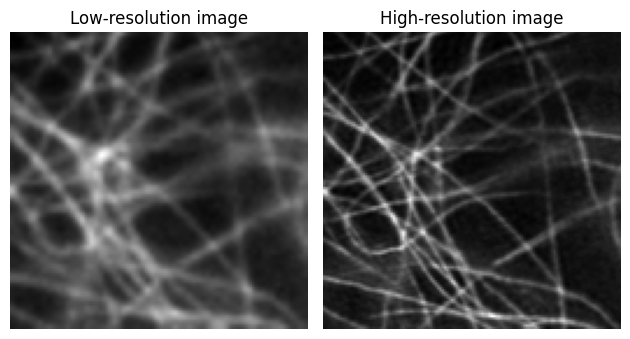

In [22]:
import matplotlib.pyplot as plt
import numpy as np

low_res_image, high_res_image = \
    train_dataset[np.random.randint(0, len(train_dataset))]

plt.figure()

plt.subplot(1, 2, 1)
plt.imshow(low_res_image.permute(1, 2, 0), cmap="gray")
plt.title("Low-resolution image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(high_res_image.permute(1, 2, 0), cmap="gray")
plt.title("High-resolution image")
plt.axis("off")

plt.tight_layout()
plt.savefig("fig_10_C1.pdf", bbox_inches="tight")  ### plt.show()

## Adapting the Diffusion Process for Super-Resolution

Define the device on which the computations are performed ...

In [23]:
import torch

def get_device():
    """Select device where to perform computations."""
    if torch.cuda.is_available():
        return torch.device("cuda:0")
    ### elif torch.backends.mps.is_available():
    ###     return torch.device("mps")
    else:
        return torch.device("cpu")

In [24]:
device = get_device()

In [25]:
print(device)

cpu


... implement the reverse diffusion for super-resolution ...

In [26]:
from tqdm import tqdm

class Diffusion:
    """Denoising diffusion probabilstic model (DDPM)."""
    
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02,
                 img_size=28, device=device):
        """Initialize the diffusion model."""
        self.noise_steps, self.beta_start, self.beta_end, self.device = \
            noise_steps, beta_start, beta_end, device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        
        self.img_size = img_size

    def prepare_noise_schedule(self):
        """Prepare the noise schedule."""
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def forward_diffusion(self, x, t):
        """Implement the forward diffusion process."""
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = \
            torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        noise = torch.randn_like(x)

        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise
    
    def reverse_diffusion(self, model, n_images, n_channels, 
                          position_encoding_dim, position_encoding_function,
                          fix_noise=None, save_time_steps=None, 
                          input_image=None):
        """Reverse diffusion process"""
        with torch.no_grad():
            if fix_noise is not None:
                x = fix_noise.to(self.device)
            else:
                x = torch.randn(
                    (n_images, n_channels, self.img_size, self.img_size)
                ).to(self.device)
            
            denoised_images = []
            for i in tqdm(reversed(range(0, self.noise_steps)),
                          desc="U-Net inference", total=self.noise_steps):
                t = (torch.ones(n_images) * i).long()
                t_pos_enc = position_encoding_function(
                    t.unsqueeze(1), position_encoding_dim
                ).to(self.device)

                if input_image is None:
                    predicted_noise = model(x=x, t=t_pos_enc)
                else:
                    predicted_noise = model(
                        torch.cat((input_image.to(self.device), x), dim=1),
                        t_pos_enc)

                alpha = self.alpha[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                
                noise = torch.randn_like(x) if i > 0 else torch.zeros_like(x)
                    
                x = (1 / torch.sqrt(alpha) * (x - ((1 - alpha) 
                    / torch.sqrt(1 - alpha_bar)) * predicted_noise) 
                    + torch.sqrt(1-alpha) * noise)

                if i in save_time_steps: denoised_images.append(x)

            denoised_images = torch.stack(denoised_images)
            denoised_images = denoised_images.swapaxes(0, 1)
            return denoised_images

## Defining the Conditional Attention U-Net

In [27]:
import deeplay as dl

position_encoding_dim = 256

unet = dl.AttentionUNet(
    in_channels=2, channels=[32, 64, 128], base_channels=[256, 256], 
    channel_attention=[False, False, False], out_channels=1, 
    position_embedding_dim=position_encoding_dim,
)
unet.build()
unet.to(device);

print(unet)

AttentionUNet(
  (encoder): UNetEncoder(
    (blocks): LayerList(
      (0): FeatureIntegrationModule(
        (blocks): LayerList(
          (0): Block(
            (layer): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
            (activation): GELU(approximate='none')
          )
          (1): Block(
            (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
            (activation): GELU(approximate='none')
          )
        )
        (res_block): Conv2d(2, 32, kernel_size=(1, 1), stride=(1, 1))
        (feed_forward_position_embedding): Linear(in_features=256, out_features=32, bias=True)
      )
      (1): FeatureIntegrationModule(
        (blocks): LayerList(
          (0): Block(
            (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (normalization)

## Training the Conditional Diffusion Model

Define the data loaders ...

In [28]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

... instantiate the diffusion class ...

In [29]:
diffusion = Diffusion(noise_steps=2000, img_size=128, beta_start=1e-6,
                      beta_end=0.01)

... define the loss function ...

In [30]:
criterion = torch.nn.L1Loss()

... define the position encoding function ...

In [31]:
def positional_encoding(t, enc_dim):
    """Encode position information with a sinusoid."""
    scaled_positions = torch.arange(0, enc_dim, 2).float() / enc_dim
    frequency = 10000 ** scaled_positions
    inverse_frequency = (1.0 / frequency).to(t.device)
    x = t.repeat(1, enc_dim // 2) * inverse_frequency
    pos_enc_a, pos_enc_b = torch.sin(x), torch.cos(x)
    pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
    return pos_enc

... define the optimizer ...

In [32]:
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)

... implement the function to prepare the data for super-resolution task ...

In [33]:
def prepare_data(input_image, target_image, noise_steps=1000, device=device):
    """Prepare data."""
    batch_size = input_image.shape[0]
    t = torch.randint(low=0, high=noise_steps, size=(batch_size,)).to(device)
    input_image, target_image = input_image.to(device), target_image.to(device)
    x_t, noise = diffusion.forward_diffusion(target_image, t)
    x_t = torch.cat((input_image, x_t), dim=1)
    t = positional_encoding(t.unsqueeze(1), position_encoding_dim)
    return x_t.to(device), t.to(device), noise.to(device)

... implement the training loop ...

In [34]:
import time
from datetime import timedelta

epochs = 30

train_loss = []
for epoch in range(epochs):
    unet.train()
    
    start_time = time.time()
    num_batches = len(train_loader)

    print("\n" + f"Epoch {epoch + 1}/{epochs}" + "\n" + "_" * 10)
    
    running_loss = 0.0
    for batch_idx, (input_images, target_images) \
        in enumerate(train_loader, start=0):
        x_t, t, noise = prepare_data(input_images, target_images)

        outputs = unet(x=x_t, t=t)

        optimizer.zero_grad()
        loss = criterion(outputs, noise)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx + 1}/{num_batches}: "
                  + f"Train loss: {loss.item():.4f}")
        running_loss += loss.item()

    train_loss.append(running_loss / len(train_loader))
    end_time = time.time()

    print("-" * 10 + "\n" + f"Epoch {epoch + 1}/{epochs} : " 
          + f"Train loss: {train_loss[-1]:.4f}, " 
          + f"Time taken: {timedelta(seconds=end_time - start_time)}")
    
    unet.eval()
    n_images = 1
    
    for batch_idx, (test_input_images, test_target_images) \
        in enumerate(test_loader):
        generated_images = diffusion.reverse_diffusion(
            model=unet, n_images=n_images, n_channels=1,
            position_encoding_dim=position_encoding_dim,
            position_encoding_function=positional_encoding,
            input_image=test_input_images[:n_images], save_time_steps=[0],
        )
        break
    
    fig = plt.figure(figsize=(7, 3 * n_images))
    for i in range(n_images):
        image_diff_traj = generated_images[i]
        low_res_image = test_input_images[i]
        high_res_image = image_diff_traj[-1]
        target_image = test_target_images[i]

        plt.subplot(n_images, 3, i * 3 + 1)
        plt.imshow(low_res_image.permute(1, 2, 0), cmap="gray")
        plt.title("Input")
        plt.axis("off")
        
        plt.subplot(n_images, 3, i * 3 + 2)
        plt.imshow(high_res_image.permute(1, 2, 0).cpu().numpy(), cmap="gray")
        plt.title("Output")
        plt.axis("off")
        
        plt.subplot(n_images, 3, i * 3 + 3)
        plt.imshow(target_image.permute(1, 2, 0), cmap="gray")
        plt.title("Target")
        plt.axis("off")

    plt.tight_layout()
    plt.savefig(f"fig_10_C2_{epoch}.pdf", bbox_inches="tight")  ## plt.show()
    plt.close()


Epoch 1/30
__________
Batch 1/642: Train loss: 0.9096
Batch 101/642: Train loss: 0.1838
Batch 201/642: Train loss: 0.1696
Batch 301/642: Train loss: 0.1293
Batch 401/642: Train loss: 0.1347
Batch 501/642: Train loss: 0.1066
Batch 601/642: Train loss: 0.1034
----------
Epoch 1/30 : Train loss: 0.1795, Time taken: 1:14:11.055041


U-Net inference: 100%|██████████| 2000/2000 [00:51<00:00, 38.54it/s]



Epoch 2/30
__________
Batch 1/642: Train loss: 0.1566
Batch 101/642: Train loss: 0.1077


KeyboardInterrupt: 